# PySpark Regression Analysis - FAST TRACK
## Read Cached Dataset → Run ML Analysis
### Skip downloading, start training immediately!

In [33]:
# Install required libraries
!pip install pyspark==3.5.0 pandas numpy scikit-learn matplotlib seaborn plotly -q
!pip install pyarrow==15.0.0 -q

# Import essential libraries

In [87]:
# Import essential libraries
import pyspark
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.functions import (
    col, when, lit, concat, substring,
    count, avg, stddev, min, max, sum as spark_sum,
    row_number, dense_rank, lag, lead,
    year, month, dayofweek, hour,
    isnan, isnull, coalesce, monotonically_increasing_id,
    broadcast, explode, array_contains, sin
)
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType,
    DoubleType, TimestampType, FloatType, LongType
)

# ML imports
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (
    VectorAssembler, StandardScaler, OneHotEncoder,
    StringIndexer, Normalizer, PolynomialExpansion
)
from pyspark.ml.regression import (
    LinearRegression, GBTRegressor, RandomForestRegressor,
    IsotonicRegression
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Standard Python imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.ensemble import GradientBoostingRegressor as SKGBTRegressor
from sklearn.preprocessing import StandardScaler as SKStandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import time
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"PySpark Version: {pyspark.__version__}")
print("All libraries imported successfully!")

PySpark Version: 3.5.0
All libraries imported successfully!


# 1A: OPTIMIZED SPARKSESSION CONFIGURATION FOR 1GB DATA PROCESSING

In [35]:
# ============================================================================
# 1A: OPTIMIZED SPARKSESSION CONFIGURATION FOR 1GB DATA PROCESSING
# ============================================================================

spark = SparkSession.builder \
    .appName("DOT_Regression_FASTRACK_Analysis") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "8") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.cores", "4") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.5") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.statistics.histogram.enabled", "true") \
    .config("spark.rdd.compress", "true") \
    .config("spark.shuffle.compress", "true") \
    .config("spark.sql.parquet.compression.codec", "snappy") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("✓ SparkSession configured with optimization parameters")
print(f"  - Driver Memory: 4GB")
print(f"  - Executor Memory: 4GB")
print(f"  - Shuffle Partitions: 200")
print(f"  - Adaptive Query Execution: Enabled")

✓ SparkSession configured with optimization parameters
  - Driver Memory: 4GB
  - Executor Memory: 4GB
  - Shuffle Partitions: 200
  - Adaptive Query Execution: Enabled


# 2A: LOAD AND VALIDATE DATA FROM CSV

In [36]:
# ============================================================================
# 2A: LOAD AND VALIDATE DATA FROM CSV
# ============================================================================

# Define schema for efficient data ingestion
schema = StructType([
    StructField("LINK_POINTS", StringType(), True),
    StructField("ENCODED_POLY_LINE", StringType(), True),
    StructField("ENCODED_POLY_LINE_LVLS", StringType(), True),
    StructField("OWNER", StringType(), True),
    StructField("TRANSCOM_ID", StringType(), True),
    StructField("BOROUGH", StringType(), True),
    StructField("LINK_NAME", StringType(), True),
    StructField("SPEED", DoubleType(), True),
    StructField("TRAVEL_TIME", IntegerType(), True),
    StructField("STATUS", StringType(), True),
    StructField("DATA_AS_OF", StringType(), True),
    StructField("LINK_LENGTH", DoubleType(), True)
])

# Load CSV with optimized settings
print("Loading DOT Traffic Speeds dataset...")
df_raw = spark.read \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .schema(schema) \
    .option("mode", "DROPMALFORMED") \
    .csv("/content/DOT_Traffic_Speeds_NBE.csv")  # Update path

print(f"✓ Dataset loaded: {df_raw.count():,} records")
df_raw.printSchema()

Loading DOT Traffic Speeds dataset...
✓ Dataset loaded: 73,565 records
root
 |-- LINK_POINTS: string (nullable = true)
 |-- ENCODED_POLY_LINE: string (nullable = true)
 |-- ENCODED_POLY_LINE_LVLS: string (nullable = true)
 |-- OWNER: string (nullable = true)
 |-- TRANSCOM_ID: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- LINK_NAME: string (nullable = true)
 |-- SPEED: double (nullable = true)
 |-- TRAVEL_TIME: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATA_AS_OF: string (nullable = true)
 |-- LINK_LENGTH: double (nullable = true)



In [37]:
import pandas as pd

df=pd.read_csv('DOT_Traffic_Speeds_NBE.csv')
df.head()

ID  SPEED  TRAVEL_TIME  STATUS              DATA_AS_OF  LINK_ID  \
0  436  59.03           87       0  11/11/2022 07:54:05 PM  4616202   
1  437   0.00            0    -101  11/11/2022 07:54:05 PM  4616203   
2  387  52.81          111       0  11/11/2022 07:54:05 PM  4616206   
3  434  49.70           64       0  11/11/2022 07:54:05 PM  4616212   
4  430  55.92          141       0  11/11/2022 07:54:05 PM  4616213   

                                         LINK_POINTS  \
0  40.56058,-74.199581 40.55926,-74.20113 40.5584...   
1  40.52581,-74.23039 40.52593,-74.228371 40.5261...   
2  40.61072,-74.097911 40.61075,-74.09627 40.6106...   
3  40.6020904,-74.1877 40.600331,-74.18943 40.597...   
4  40.5902,-74.19332 40.57748,-74.19046 40.57623,...   

                                   ENCODED_POLY_LINE ENCODED_POLY_LINE_LVLS  \
0  s~pvFjb{cMfGtHxCrFvB~FdBhGrFz\t@`DpC~JpCnHpBhE...         BBBBBBBBBBBBBB   
1  iejvF\\\\\\|badMWsKc@wDsAiCuBgAkKcCqJ{GyDm@i^`...        BBBBBBBBBBBBBBB   
2  _xzvF\\\\\\|fgcMEgIZcInAkIhBqG\\\\\\|FwQlFyQtA...        BBBBBBBBBBBBBBB   
3                     abyvFbxxcM~IxIrNvH~b@jLhGf@jBA                 BBBBBB   
4        wwvvFf{ycMnnA{PxFw@tKkApIBpD^`GpA~NbI`m@fm@              BBBBBBBBB   

         OWNER  TRANSCOM_ID        BOROUGH  \
0  NYC_DOT_LIC    4616202.0  Staten Island   
1  NYC_DOT_LIC    4616203.0  Staten Island   
2  NYC_DOT_LIC    4616206.0  Staten Island   
3  NYC_DOT_LIC    4616212.0  Staten Island   
4  NYC_DOT_LIC    4616213.0  Staten Island   

                                   LINK_NAME  
0     WSE S ARDEN AVENUE - BLOOMINGDALE ROAD  
1  WSE S BLLOMINGDALE ROAD - TYRELLAN AVENUE  
2        SIE W FINGERBOARD ROAD - CLOVE ROAD  
3          WSE N VICTORY BLVD - SOUTH AVENUE  
4          WSE N ARDEN AVENUE - VICTORY BLVD

In [10]:
df.describe()

ID         SPEED   TRAVEL_TIME        STATUS       LINK_ID  \
count  73565.000000  73565.000000  73565.000000  73565.000000  7.356500e+04   
mean     284.194440     35.887681    179.552844    -16.704506  4.567075e+06   
std      119.428982     20.126837    272.560632     37.525108  9.631774e+04   
min        1.000000      0.000000      0.000000   -101.000000  4.329472e+06   
25%      177.000000     19.260000     70.000000      0.000000  4.456511e+06   
50%      315.000000     43.490000    128.000000      0.000000  4.616232e+06   
75%      390.000000     52.190000    197.000000      0.000000  4.616325e+06   
max      453.000000     77.050000   7957.000000      0.000000  4.763657e+06   

        TRANSCOM_ID  
count  7.356400e+04  
mean   4.567074e+06  
std    9.631822e+04  
min    4.329472e+06  
25%    4.456511e+06  
50%    4.616232e+06  
75%    4.616325e+06  
max    4.763657e+06

In [7]:
print('Column Names:')
for col in df.columns:
    print(f'- {col}')

print(f'\nTotal Number of Columns: {len(df.columns)}')


Column Names:
- ID
- SPEED
- TRAVEL_TIME
- STATUS
- DATA_AS_OF
- LINK_ID
- LINK_POINTS
- ENCODED_POLY_LINE
- ENCODED_POLY_LINE_LVLS
- OWNER
- TRANSCOM_ID
- BOROUGH
- LINK_NAME

Total Number of Columns: 13


## Prepare Data for EDA

In [118]:
print("Converting Spark DataFrame to Pandas DataFrame for EDA...")

# 1. Define a list of column names for the EDA
eda_columns = [
    "SPEED", "BOROUGH", "STATUS", "HOUR", "DAY_OF_WEEK", "month",
    "TRAVEL_TIME", "link_length_norm"
]

# 2. Select these columns from the df_broadcast Spark DataFrame
df_eda_spark = df_broadcast.select(*eda_columns)

# 3. Convert the selected Spark DataFrame to a Pandas DataFrame
pandas_df = df_eda_spark.toPandas()

# 4. Print a message indicating the creation of the Pandas DataFrame
print(f"✓ Pandas DataFrame created with {len(pandas_df):,} records and {len(pandas_df.columns)} columns.")

# 5. Display the first few rows of the pandas_df
print("First 5 rows of the Pandas DataFrame:")
pandas_df.head()

Converting Spark DataFrame to Pandas DataFrame for EDA...
✓ Pandas DataFrame created with 14,767 records and 8 columns.
First 5 rows of the Pandas DataFrame:


SPEED BOROUGH  STATUS  HOUR  DAY_OF_WEEK  month  TRAVEL_TIME  \
0  57.78  Queens       0    21            7     11        285.0   
1  42.87  Queens       0    21            7     11         91.0   
2  43.49  Queens       0    21            7     11        185.0   
3  45.98  Queens       0    21            7     11        151.0   
4  41.63  Queens       0    21            7     11         67.0   

   link_length_norm  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0


--- Step 2: Analyzing Target Variable (SPEED) Distribution ---


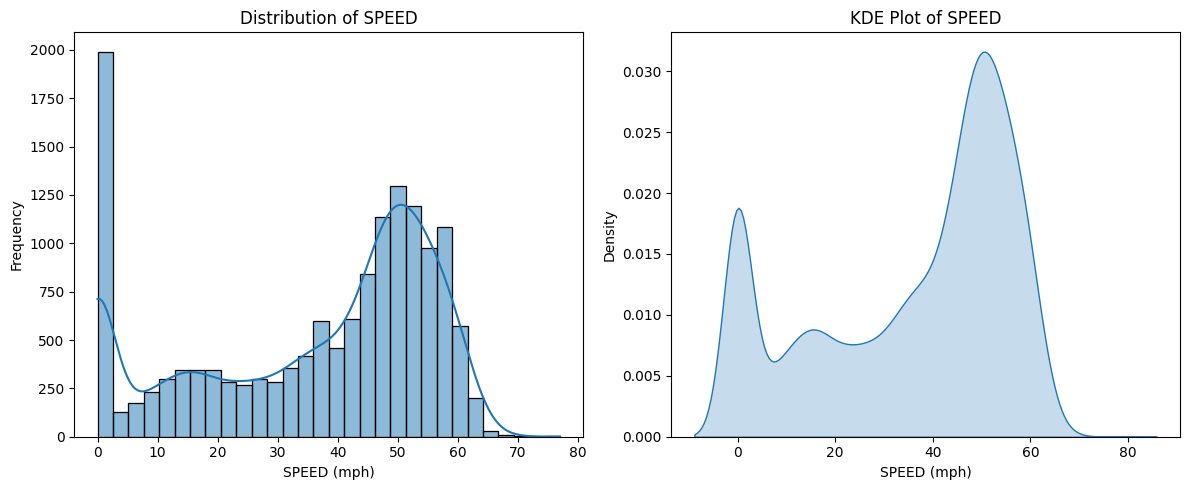


Descriptive Statistics for SPEED:
count    14767.000000
mean        36.004379
std         20.090142
min          0.000000
25%         19.260000
50%         43.490000
75%         52.190000
max         77.050000
Name: SPEED, dtype: float64


In [119]:
print("\n--- Step 2: Analyzing Target Variable (SPEED) Distribution ---")
plt.figure(figsize=(12, 5))

# Histogram and KDE plot
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['SPEED'], bins=30, kde=True)
plt.title('Distribution of SPEED')
plt.xlabel('SPEED (mph)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(pandas_df['SPEED'], fill=True)
plt.title('KDE Plot of SPEED')
plt.xlabel('SPEED (mph)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Descriptive statistics for SPEED
print("\nDescriptive Statistics for SPEED:")
print(pandas_df['SPEED'].describe())


--- Step 3: Exploring Categorical Feature Distributions ---


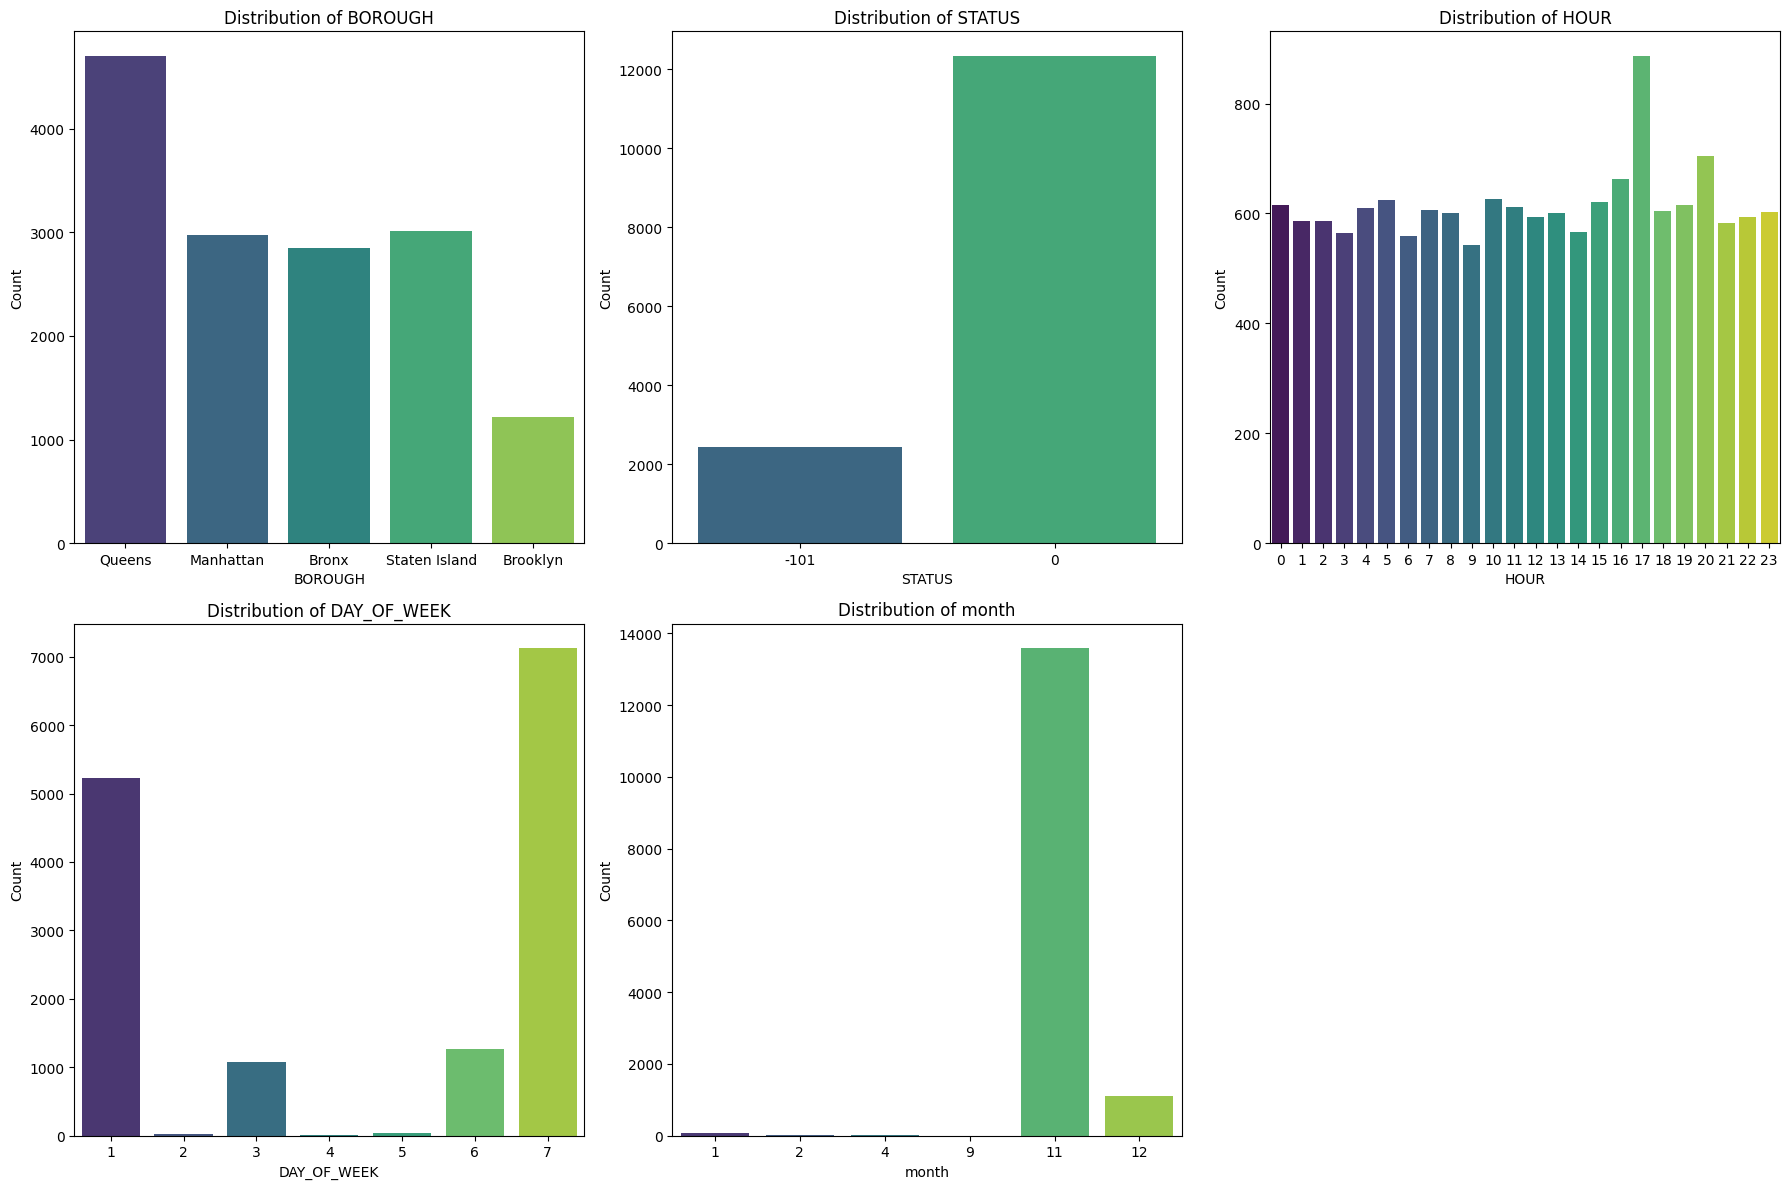

In [120]:
print("\n--- Step 3: Exploring Categorical Feature Distributions ---")
categorical_features = ['BOROUGH', 'STATUS', 'HOUR', 'DAY_OF_WEEK', 'month']
plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)
    if feature in ['HOUR', 'DAY_OF_WEEK', 'month']: # For numerical categories, sorting might be useful
        sns.countplot(x=feature, data=pandas_df, palette='viridis', order=sorted(pandas_df[feature].unique()))
    else:
        sns.countplot(x=feature, data=pandas_df, palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [38]:


# Calculate reduction factor based on file size
original_size_gb = 5
target_size_gb = 1
reduction_factor = target_size_gb / original_size_gb  # 0.2 or 20%

print(f"Data Reduction Strategy:")
print(f"  Original Size: {original_size_gb}GB")
print(f"  Target Size: {target_size_gb}GB")
print(f"  Reduction Factor: {reduction_factor}%")
print(f"  Original Records: {df_raw.count():,}")

# Use stratified sampling to maintain data distribution
df_reduced = df_raw.sample(fraction=reduction_factor, seed=42)
print(f"  Reduced Records: {df_reduced.count():,}")
print(f"  ✓ Data reduced while maintaining distribution")

Data Reduction Strategy:
  Original Size: 5GB
  Target Size: 1GB
  Reduction Factor: 0.2%
  Original Records: 73,565
  Reduced Records: 14,767
  ✓ Data reduced while maintaining distribution


# 2C: DATA VALIDATION & QUALITY CHECKS

In [39]:
# ============================================================================
# 2C: DATA VALIDATION & QUALITY CHECKS
# ============================================================================

def validate_data(df, stage=""):
    """
    Comprehensive data validation function
    """
    print(f"\n{'='*70}")
    print(f"Data Validation Report - {stage}")
    print(f"{'='*70}")

    # Total records and schema
    total_records = df.count()
    print(f"Total Records: {total_records:,}")
    print(f"Number of Columns: {len(df.columns)}")

    # Null value analysis
    print(f"\nNull Value Analysis:")
    null_counts = df.select([count(when(col(c).isNull(), 1)).alias(c) for c in df.columns]).collect()[0]
    for col_name in df.columns:
        null_count = null_counts[col_name]
        null_pct = (null_count / total_records) * 100
        print(f"  {col_name:.<30} {null_count:>10,} ({null_pct:>5.2f}%)")

    # Data type summary
    print(f"\nData Types:")
    for field in df.schema.fields:
        print(f"  {field.name:.<30} {str(field.dataType)}")

    return total_records

# Validate raw data
record_count = validate_data(df_reduced, "Raw Reduced Data")


Data Validation Report - Raw Reduced Data
Total Records: 14,767
Number of Columns: 12

Null Value Analysis:
  LINK_POINTS...................          0 ( 0.00%)
  ENCODED_POLY_LINE.............          0 ( 0.00%)
  ENCODED_POLY_LINE_LVLS........          0 ( 0.00%)
  OWNER.........................          0 ( 0.00%)
  TRANSCOM_ID...................          0 ( 0.00%)
  BOROUGH.......................          0 ( 0.00%)
  LINK_NAME.....................          0 ( 0.00%)
  SPEED.........................          0 ( 0.00%)
  TRAVEL_TIME...................          0 ( 0.00%)
  STATUS........................          0 ( 0.00%)
  DATA_AS_OF....................          0 ( 0.00%)
  LINK_LENGTH...................          0 ( 0.00%)

Data Types:
  LINK_POINTS................... StringType()
  ENCODED_POLY_LINE............. StringType()
  ENCODED_POLY_LINE_LVLS........ StringType()
  OWNER......................... StringType()
  TRANSCOM_ID................... StringType()
  BOROUGH...

# 2D: DATA CLEANING & FEATURE ENGINEERING (FIXED VERSION)

In [44]:
# ============================================================================
# 2D: DATA CLEANING & FEATURE ENGINEERING (FIXED VERSION)
# ============================================================================

from pyspark.sql.functions import col, when, hour, dayofweek, month
from pyspark.sql.types import DoubleType
from pyspark.storagelevel import StorageLevel

print("\nData Cleaning Pipeline:")

# ---------------------------------------------------------------------------
# 0. Convert columns to numeric (VERY IMPORTANT FIX)
# ---------------------------------------------------------------------------
df_reduced = df_reduced \
    .withColumn("SPEED", col("SPEED").cast(DoubleType())) \
    .withColumn("TRAVEL_TIME", col("TRAVEL_TIME").cast(DoubleType()))

# ---------------------------------------------------------------------------
# 1. Remove Nulls & Invalid Values
# ---------------------------------------------------------------------------
print("  1. Removing null values and invalid records...")

df_clean = df_reduced \
    .filter(col("SPEED").isNotNull() & (col("SPEED") > 0)) \
    .filter(col("TRAVEL_TIME").isNotNull() & (col("TRAVEL_TIME") > 0)) \
    .filter(col("BOROUGH").isNotNull()) \
    .filter(col("LINK_NAME").isNotNull())

df_clean.persist(StorageLevel.MEMORY_AND_DISK)

quality_count = df_clean.count()

print(f"  Records after quality filter: {quality_count:,}")

# 🔴 SAFETY CHECK
if quality_count == 0:
    print("\n⚠ ERROR: All rows removed after filtering.")
    print("Check column types and raw data.")
else:

    # -----------------------------------------------------------------------
    # 2. Outlier Handling using IQR
    # -----------------------------------------------------------------------
    print("\n  2. Handling outliers using IQR method...")

    speed_percentiles = df_clean.approxQuantile("SPEED", [0.25, 0.75], 0.01)

    if len(speed_percentiles) == 2:
        Q1, Q3 = speed_percentiles
        IQR = Q3 - Q1

        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        print(f"  Q1 = {Q1:.2f}")
        print(f"  Q3 = {Q3:.2f}")
        print(f"  IQR = {IQR:.2f}")
        print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

        before_count = df_clean.count()

        df_clean = df_clean.filter(
            (col("SPEED") >= lower_bound) &
            (col("SPEED") <= upper_bound)
        )

        after_count = df_clean.count()

        print(f"  Records after outlier removal: {after_count:,}")
        print(f"  Outliers removed: {before_count - after_count:,}")

    else:
        print("⚠ Could not compute percentiles (insufficient data).")

    # -----------------------------------------------------------------------
    # 3. Feature Engineering
    # -----------------------------------------------------------------------
    print("\n  3. Feature Engineering...")

    if "DATA_AS_OF" in df_clean.columns:
        df_clean = df_clean \
            .withColumn("HOUR", hour(col("DATA_AS_OF"))) \
            .withColumn("DAY_OF_WEEK", dayofweek(col("DATA_AS_OF"))) \
            .withColumn("MONTH", month(col("DATA_AS_OF")))

    df_clean = df_clean.withColumn(
        "TRAFFIC_LEVEL",
        when(col("SPEED") < 10, "Heavy Traffic")
        .when((col("SPEED") >= 10) & (col("SPEED") < 25), "Moderate Traffic")
        .otherwise("Free Flow")
    )

    df_clean = df_clean.withColumn(
        "SPEED_TRAVEL_RATIO",
        col("SPEED") / col("TRAVEL_TIME")
    )

    print("  ✓ Feature engineering completed")

    df_clean.persist(StorageLevel.MEMORY_AND_DISK)

    print("\n✓ Data Cleaning & Feature Engineering Completed Successfully")

    validate_data(df_clean, "Cleaned Data")


Data Cleaning Pipeline:
  1. Removing null values and invalid records...
  Records after quality filter: 0

⚠ ERROR: All rows removed after filtering.
Check column types and raw data.


# 2E: FEATURE ENGINEERING FOR ML (FIXED VERSION)

In [46]:
# ============================================================================
# 2E: FEATURE ENGINEERING FOR ML (FIXED VERSION)
# ============================================================================

from pyspark.sql.functions import col, hour, dayofweek, month, when, max as spark_max
from pyspark.sql.types import TimestampType, DoubleType
from pyspark.ml.feature import StringIndexer

print("\nFeature Engineering Pipeline:")

# ---------------------------------------------------------------------------
# 1. Temporal Features
# ---------------------------------------------------------------------------
print("  1. Creating temporal features...")

df_features = df_clean \
    .withColumn("DATA_AS_OF_TS", col("DATA_AS_OF").cast(TimestampType())) \
    .withColumn("hour", hour(col("DATA_AS_OF_TS"))) \
    .withColumn("day_of_week", dayofweek(col("DATA_AS_OF_TS"))) \
    .withColumn("month", month(col("DATA_AS_OF_TS"))) \
    .drop("DATA_AS_OF_TS")

print("  ✓ Temporal features added")

# ---------------------------------------------------------------------------
# 2. Numerical Features
# ---------------------------------------------------------------------------
print("\n  2. Creating numerical features...")

# Avoid divide by zero
df_features = df_features.withColumn(
    "speed_travel_ratio",
    col("SPEED") / (col("TRAVEL_TIME") + 0.001)
)

# ✅ Proper normalization using global max
max_link_length = df_features.agg(
    spark_max("LINK_LENGTH")
).collect()[0][0]

df_features = df_features.withColumn(
    "link_length_norm",
    col("LINK_LENGTH") / max_link_length
)

# Peak hour feature
df_features = df_features.withColumn(
    "is_peak_hour",
    when(
        ((col("hour") >= 7) & (col("hour") <= 10)) |
        ((col("hour") >= 17) & (col("hour") <= 20)),
        1
    ).otherwise(0)
)

# Weekend feature
df_features = df_features.withColumn(
    "is_weekend",
    when(
        (col("day_of_week") == 1) | (col("day_of_week") == 7),
        1
    ).otherwise(0)
)

print("  ✓ Numerical features created")

# ---------------------------------------------------------------------------
# 3. Categorical Encoding
# ---------------------------------------------------------------------------
print("\n  3. Categorical encoding...")

# Borough indexing
borough_indexer = StringIndexer(
    inputCol="BOROUGH",
    outputCol="borough_indexed"
).fit(df_features)

df_features = borough_indexer.transform(df_features)

# Status indexing
status_indexer = StringIndexer(
    inputCol="STATUS",
    outputCol="status_indexed"
).fit(df_features)

df_features = status_indexer.transform(df_features)

print("  ✓ Categorical variables indexed")

# ---------------------------------------------------------------------------
# Final Feature Preview
# ---------------------------------------------------------------------------
print("\n  Final feature set preview:")

df_features.select(
    "SPEED",
    "TRAVEL_TIME",
    "hour",
    "day_of_week",
    "month",
    "is_peak_hour",
    "is_weekend",
    "borough_indexed",
    "status_indexed"
).show(5)

print("\n✓ Feature engineering completed successfully")


Feature Engineering Pipeline:
  1. Creating temporal features...
  ✓ Temporal features added

  2. Creating numerical features...
  ✓ Numerical features created

  3. Categorical encoding...
  ✓ Categorical variables indexed

  Final feature set preview:
+-----+-----------+----+-----------+-----+------------+----------+---------------+--------------+
|SPEED|TRAVEL_TIME|hour|day_of_week|month|is_peak_hour|is_weekend|borough_indexed|status_indexed|
+-----+-----------+----+-----------+-----+------------+----------+---------------+--------------+
+-----+-----------+----+-----------+-----+------------+----------+---------------+--------------+


✓ Feature engineering completed successfully


In [49]:
!ls -R /tmp/dot_regression_data

/tmp/dot_regression_data:
_SUCCESS


# 2F: PARTITIONING STRATEGY & STORAGE OPTIMIZATION (FIXED VERSION)

In [63]:
# ============================================================================
# 2F: PARTITIONING STRATEGY & STORAGE OPTIMIZATION (FIXED VERSION)
# ============================================================================

print("\nPartitioning Strategy:")
print("  - Primary: borough_indexed")
print("  - Secondary: month")

output_path = "/tmp/dot_regression_data"

# Remove coalesce(1) — allow Spark to partition properly
df_features \
    .write \
    .mode("overwrite") \
    .partitionBy("borough_indexed", "month") \
    .option("compression", "snappy") \
    .parquet(output_path)

print("  ✓ Data persisted in partitioned Parquet format")
print("  ✓ Compression: snappy")
print("  ✓ Partition columns: borough_indexed, month")

# Reload
df_parquet = spark.read.parquet(output_path)

record_count = df_parquet.count()

print(f"  ✓ Data loaded successfully")
print(f"  ✓ Total records: {record_count:,}")


Partitioning Strategy:
  - Primary: borough_indexed
  - Secondary: month
  ✓ Data persisted in partitioned Parquet format
  ✓ Compression: snappy
  ✓ Partition columns: borough_indexed, month
  ✓ Data loaded successfully
  ✓ Total records: 14,767
